In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fastai.tabular.all import *
from tsai.all import *

/home/luca/micromamba/envs/fastai/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/luca/micromamba/envs/fastai/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
from utils.preprocess_data import load_dataset, adjust_dimensions, standardize, minmax

In [70]:
x_train, y_train, x_test, y_test, act_dic = load_dataset()

Missing file: input/separated/5_standing/7.csv
Missing file: input/separated/7_bending_backward/19.csv

x_train shape: (16262, 10, 53)
y_train shape: (16262, 14)
x_val shape: (4893, 10, 53)
y_val shape: (4893, 14)


In [71]:
scaler = None
# scaler = standardize()
# scaler = minmax()

In [72]:
if scaler:
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

In [73]:
# x_train, x_test = adjust_dimensions(x_train, x_test, 15)
x_train, x_test, pca_components = adjust_dimensions(x_train, x_test, 15, return_components=True)

In [39]:
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)

In [40]:
x_train = np.swapaxes(x_train, -1, -2)
x_test = np.swapaxes(x_test, -1, -2)
x_train.shape, x_test.shape

((16262, 18, 10), (4893, 18, 10))

In [41]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

In [42]:
splits = (L(np.arange(len(x_train)), use_list=True),
          L(np.arange(len(x_train), len(x)), use_list=True))
splits

((#16262) [0,1,2,3,4,5,6,7,8,9...],
 (#4893) [16262,16263,16264,16265,16266,16267,16268,16269,16270,16271...])

In [43]:
t = TSTensor(x, torch.float32)
t

TSTensor(samples:21155, vars:18, len:10, device=cpu, dtype=torch.float32)

In [44]:
splitter = IndexSplitter(splits[1])
getters = [ItemGetter(0), ItemGetter(1)]

In [45]:
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=splitter)

In [46]:
procs = [Normalize(axes=(0,2))]

In [47]:
src = itemify(t,y) # use t and not x to transform x to float dtype -> training works now

In [48]:
bs = 1024

In [49]:
dls = dblock.dataloaders(src, bs=bs, val_bs=2*bs, batch_tfms=procs)

In [50]:
# dls.show_batch(max_n=3)

In [51]:
dls.dataset[0][0]

TSTensor(vars:18, len:10, device=cpu, dtype=torch.float32)

In [52]:
dls.c

14

In [53]:
inp_vars = dls.dataset[0][0].shape[-2]
inp_vars

18

In [83]:
net = InceptionTime(inp_vars, dls.c, depth=6)
# net = InceptionTimePlus(inp_vars, dls.c)

In [84]:
# opt = ranger(wd=0.1)
# opt = ranger
opt = Adam

In [85]:
learn= Learner(dls, net, CrossEntropyLossFlat(), opt, metrics=accuracy)
# learn.summary()

SuggestedLRs(valley=0.0005754399462603033)

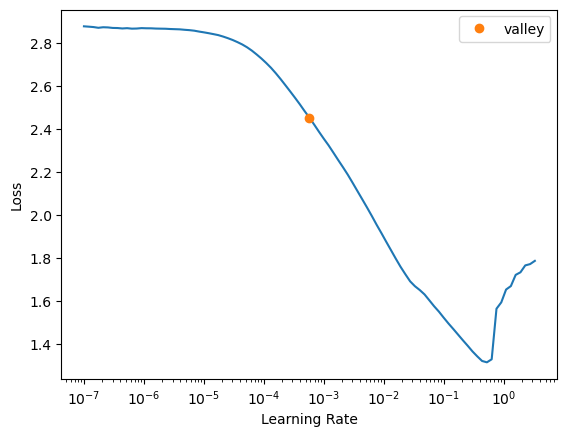

In [86]:
lr_sug = learn.lr_find()
lr_sug

In [87]:
st = time.time()
# learn.fit_flat_cos(10, lr_sug)
# learn.fit_flat_cos(20, 1e-3)
# learn.fit_one_cycle(20, lr_sug)
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.366095,2.670977,0.097077,00:04
1,1.910756,1.868975,0.603924,00:04
2,1.530298,1.047919,0.743102,00:04
3,1.171277,0.941619,0.699571,00:04
4,0.883797,0.367577,0.889025,00:04
5,0.674314,0.369522,0.877171,00:04
6,0.522616,0.446411,0.852851,00:04
7,0.409684,0.376622,0.865318,00:04
8,0.326538,0.381282,0.877376,00:04
9,0.262483,0.343141,0.889843,00:04


In [88]:
print(f"The Training took {(time.time() - st):.0f}s")

The Training took 98s


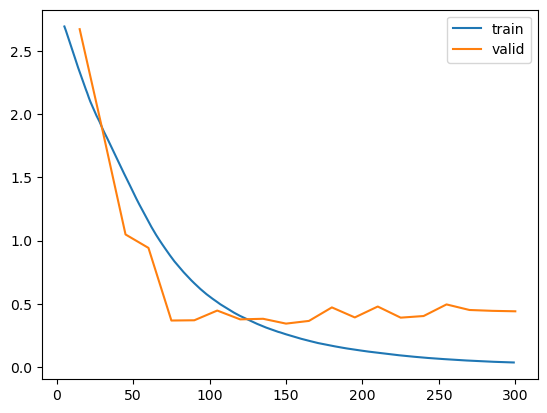

In [89]:
learn.recorder.plot_loss()

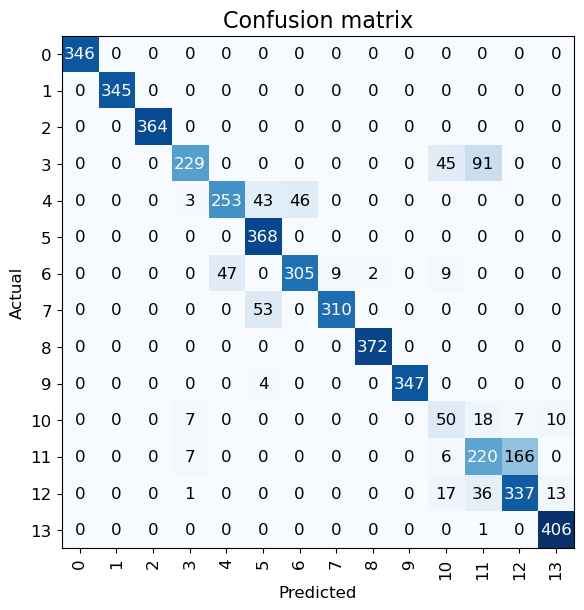

In [90]:
learn.plot_confusion_matrix()

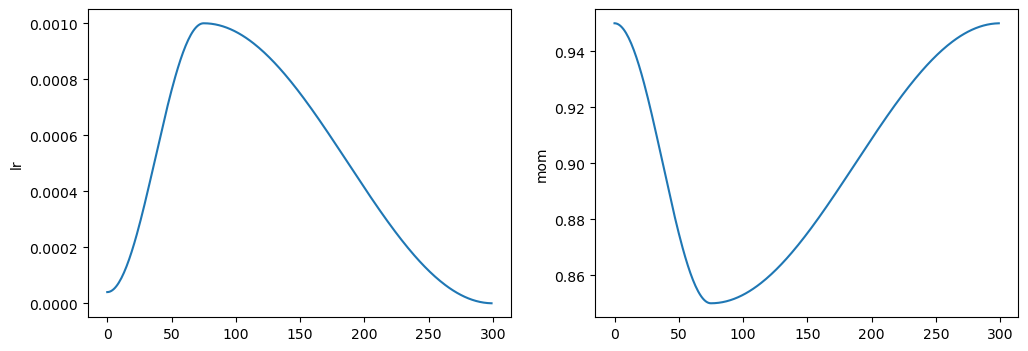

In [91]:
learn.recorder.plot_sched()